## Access Autonomous Underwater Vehicle data in Parquet
A jupyter notebook to show how to access and plot the AODN autonomous_underwater_vehicle dataset available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "autonomous_underwater_vehicle"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os


def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

Using Python 3.12.4 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python3
Creating virtualenv at: .venv
Activate with: source .venv/bin/activate
Audited 129 packages in 87ms


In [3]:
import requests
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [4]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata, plot_ts_diagram
import pyarrow.parquet as pq
import pyarrow.dataset as pds

import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

campaign_name: string
dive_name: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'campaign_name')
print(list(unique_partition_value)[0:2])  # showing a subset only

['Tasmania202302']
CPU times: user 2.05 ms, sys: 35 µs, total: 2.08 ms
Wall time: 1.76 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

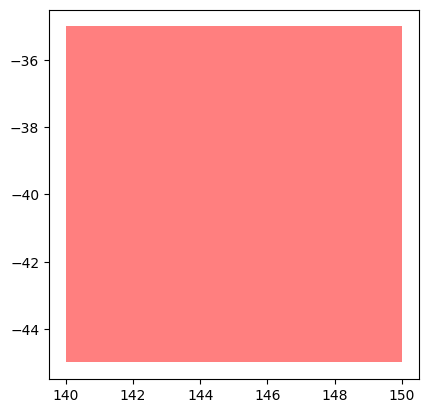

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2023, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2023, 1, 1, 0, 0, tzinfo=datetime.timezone.utc))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'campaign_name': {'type': 'string'},
 'dive_name': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comments': 'Time synchronised before diving. There after standard PC clock',
  'quality_control_set': 1,
  'quality_control_indicator': 1,
  'uncertainty': 1.1574074074074073e-05,
  'local_time_zone': '+8'},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'comments': 'Initial pos from GPS, thereafter position data is generated using SLAM image based naviagation. Relative uncertainty much smaller that the absolute uncertainty quoted here.',
  'quality_control_set': 1,
  'quality_control_indicator': 1,
  'uncertainty': '20m circle',
  'reference': 'ge

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2023-03-01', date_end='2023-03-01 09:00:00')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-45, lat_max=-40, lon_min=140, lon_max=150)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9881 entries, 0 to 9880
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   filename       9881 non-null   object        
 1   TIME           9881 non-null   datetime64[ns]
 2   LATITUDE       9881 non-null   float64       
 3   LONGITUDE      9881 non-null   float64       
 4   DEPTH          9881 non-null   float64       
 5   PSAL           6487 non-null   float64       
 6   TEMP           9881 non-null   float64       
 7   OPBS           0 non-null      float32       
 8   CPHL           0 non-null      float32       
 9   CDOM           0 non-null      float32       
 10  campaign_name  9881 non-null   category      
 11  dive_name      9881 non-null   category      
 12  timestamp      9881 non-null   category      
 13  polygon        9881 non-null   category      
dtypes: category(4), datetime64[ns](1), float32(3), float64(5), object(1)
mem

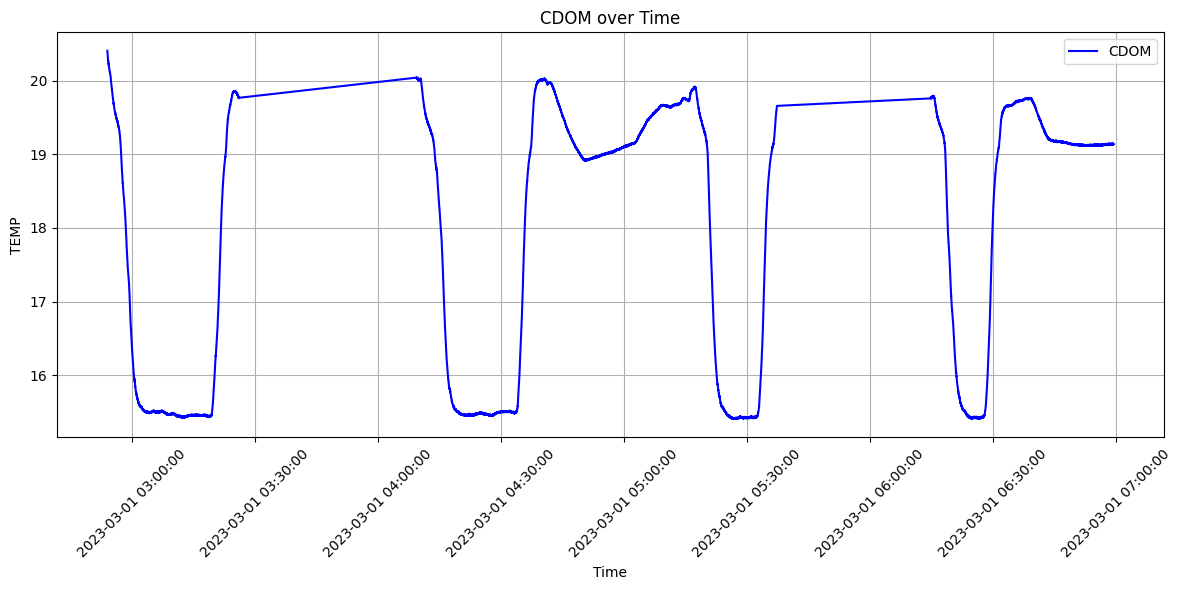

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'df' is your DataFrame
plt.figure(figsize=(12, 6))

# Plot the time series
plt.plot(df['TIME'], df['TEMP'], label='CDOM', color='blue')

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('TEMP')
plt.title('CDOM over Time')
plt.grid(True)
plt.legend()

# Formatting the x-axis for date display
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)  # Rotate x-axis labels

# Optional: Adjust the layout to make room for the rotated labels
plt.tight_layout()

# Display the plot
plt.show()


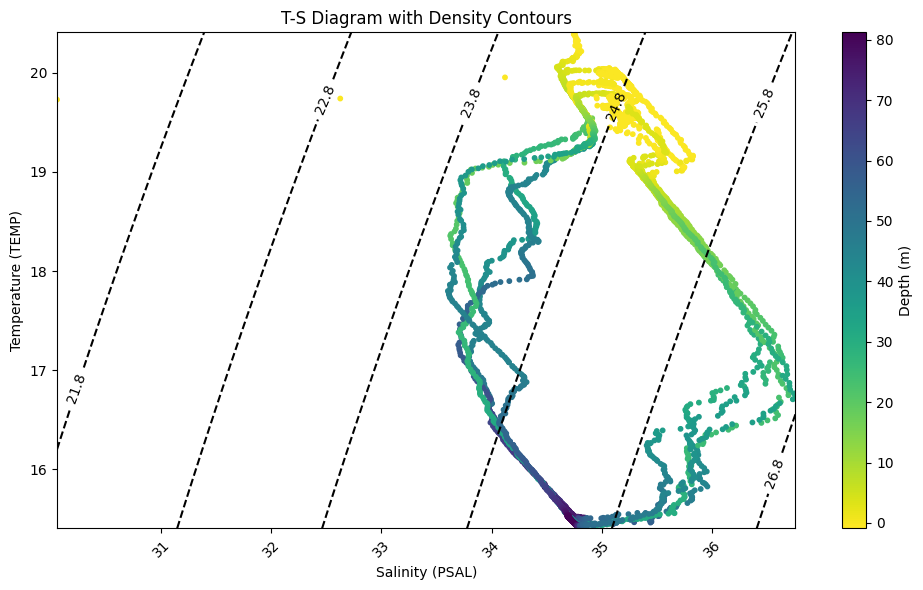

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import gsw  # TEOS-10 library


plot_ts_diagram(df)

## Create a TIME and scalar/number filter

In [15]:
expr_1 = pc.field('campaign_name') == "Tasmania202302"
filter = expr_1 & filter_time

In [16]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9881 entries, 0 to 9880
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   filename       9881 non-null   object        
 1   TIME           9881 non-null   datetime64[ns]
 2   LATITUDE       9881 non-null   float64       
 3   LONGITUDE      9881 non-null   float64       
 4   DEPTH          9881 non-null   float64       
 5   PSAL           6487 non-null   float64       
 6   TEMP           9881 non-null   float64       
 7   OPBS           0 non-null      float32       
 8   CPHL           0 non-null      float32       
 9   CDOM           0 non-null      float32       
 10  campaign_name  9881 non-null   category      
 11  dive_name      9881 non-null   category      
 12  timestamp      9881 non-null   category      
 13  polygon        9881 non-null   category      
dtypes: category(4), datetime64[ns](1), float32(3), float64(5), object(1)
mem

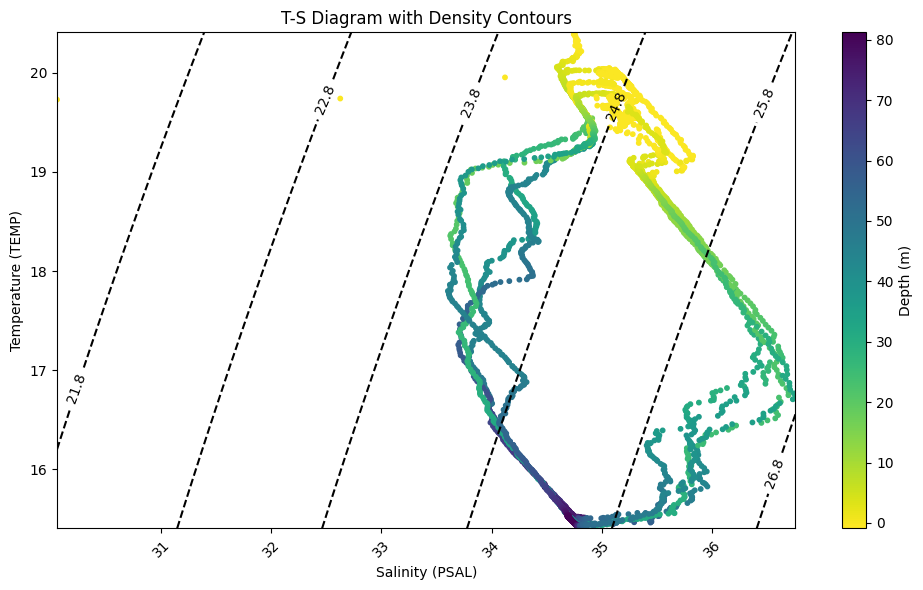

In [17]:
plot_ts_diagram(df)